In [2]:
# import packages
import time
from datetime import timedelta, datetime, date
import arrow 
import pdb
import glob 

from os.path import join
import os
from os import listdir
from os.path import isfile, join
import csv

import numpy as np
import numpy.matlib
import pandas as pd


import io
from runeq import Config, stream

import matplotlib.pyplot as plt
from matplotlib import figure
%matplotlib inline

'''
print('Download runeq, via Terminal: pip install runeq')
Rune instructions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/00_python_installation_instructions.md
documentation Rune functions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb
Make sure that runeq is up-to-date before you run by running: 
pip install pipupgrade
pipupgrade --verbose --latest --yes

'''


"\nprint('Download runeq, via Terminal: pip install runeq')\nRune instructions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/00_python_installation_instructions.md\ndocumentation Rune functions: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb\nMake sure that runeq is up-to-date before you run by running: \npip install pipupgrade\npipupgrade --verbose --latest --yes\n\n"

# Downloading Accelerometry and Symptom-scores from patients' AppleWatch recordings via Rune platform

Code requires one folder with a patient-specific folder per patient.

Code requires on folder 'config files' in main path, containing the configuration files for each specific patient. Documentation about how to create these files is given on the Rune-Github: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb.

In [3]:
# set the path to the directory in which the repo exists 
path = os.path.dirname(os.getcwd())
print(path)

/Users/jeroenhabets/Desktop/UCSF_Bradykinesia_Detection/medStateDetection


## Defining Rune-configuration files, patient-specific and user-specific

In [6]:
# set up config for Rune watch data extraction

# (https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb)


'''
Config files are patient and user specific. Open yaml-files to enter personal client key and access key.
To get keys: log in in Rune-labs as admin; click edit-pencil next to patients name;
go to Clients; make new Client; copy keys to yaml-file
'''

cfg_RCS02 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS02.yaml'))
cfg_RCS05 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS05.yaml'))
cfg_RCS06 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS06.yaml'))
cfg_RCS07 = Config(os.path.join(path,'config_files','rune_Jeroen_watch_config_RCS07.yaml'))

clients = {'RCS02' : stream.V1Client(cfg_RCS02),'RCS05' : stream.V1Client(cfg_RCS05),
          'RCS06': stream.V1Client(cfg_RCS06),'RCS07': stream.V1Client(cfg_RCS07)}

# device_ids are ID's for patient's Applewatches
deviceIDS = {'RCS02': 'S9Nj2M1Q', 'RCS05': 'fkFVvXvO', 'RCS06': 'CWTFFG3f', 'RCS07': '0Z48CCdv'}






## Downloading Apple-Watch Accelerometry Data from Rune platform

Function writes csv-files of Apple-Watch accelerometry data to defined folder.
One csv-file is created per day, for every day in the specified time span. Days in the time span without available data will be skipped.

The function requires a patient-specific folder in the path-folder, named as the patient-code (e.g. RCS02)

In [16]:
def downloadAccData(pt,y0,m0,d0,y1,m1,d1):
    '''
    Function downloads csv files with Apple watch accelerometry (without gravity) for seperate days
    within a given time period.
    Input:
    - pt = patient as string (e.g. 'RCS02' or 'RCS05')
    - y0,m0,d0 : start date of desired timeperiod (year, month, date, e.g. 2020, 5, 1)
    - y1,m1,d1 : end date of desired timeperiod (year, month, date, e.g. 2020, 6, 1)
    
    Saves csv files in patient folder within given path-folder.
    '''
    
    '''
    Configurations for extraction via Rune platform
    Source: https://github.com/rune-labs/opensource/blob/master/jupyter-notebook-templates/02_download_watch_data.ipynb
    
    Config files are patient and user specific. Open yaml-files to enter personal client key and access key.
    To get keys: log in in Rune-labs as admin; click edit-pencil next to patients name;
    go to Clients; make new Client; copy keys to yaml-file
    '''
    
    # define timespan
    def datetime_range(start=None, end=None):
        span = end - start
        for i in range(span.days + 1):
            yield start + timedelta(days=i)
    datetimeDays = list(datetime_range(start=datetime(y0, m0, d0), end=datetime(y1, m1, d1)))
    
    # loop over all days in requested timespan
    for timeStart in datetimeDays:
        # define start time of download, as required tuple
        start = time.mktime(timeStart.timetuple()) #1577865600, is equivalent to: 01/01/2020 @ 12:00am (UTC)
        # download per day, so end of download is end of day
        timeEnd = timeStart + timedelta(days=1)
        # convert end-time in required time tuple        
        end = time.mktime(timeEnd.timetuple()) # convert to unix time

        # set download parameters with set start and endtimes
        downloadParameters = {'device_id': deviceIDS[pt], 'start_time': start,'end_time': end, 'timestamp': 'unix'}

        '''
        Rune-function which makes API call for accel data, saves to CSV and outputs dataframe.
        expression=user takes data without gravity from watch.
        For acceleration with gravity use expression=accel.
        
        If interested in gyroscope data, use: clients[pt].Rotation(**downloadParameters)
        '''
        # set download parameters with specific device, start and end date
        accessor = clients[pt].Accel(**downloadParameters, expression= "user" )
        # Extraction of Rune function
        df = pd.DataFrame()
        for page in accessor.iter_csv_text():
            page_df = pd.read_csv(io.StringIO(page))
            df = df.append(page_df, ignore_index=True)
              
        # define name of day-file
        day = timeStart.strftime("%d") # generate 2-digit day code
        month = timeStart.strftime("%m") # generate 2-digit month code
        year = timeStart.strftime("%Y") # generate 4-digit year code

        if df.shape[0] < 5: # selects days without available acc data
            print('%s-%s-%s had no recording.'% ( year, month, day)) # informing about days without recording
            continue # goes further to next day without writing file
        
        fileName = '%s_%s%s%s_watch_accel.csv' % (pt, year, month, day)
        # save dataframe to a csv
        patient_dir_name = os.path.join(path,'data','%s' %pt)
        try: 
            os.makedirs(patient_dir_name)
        except OSError as error: 
            print(error)
        df.to_csv(os.path.join(patient_dir_name,fileName), index=False)
        print('%s-%s-%s is written!'% ( year, month, day))
    




In [17]:
downloadAccData(pt='RCS02', y0=2020, m0=5, d0=25, y1=2020, m1=5, d1=26)


2020 25 25 had no recording.
[Errno 17] File exists: '/Users/jeroenhabets/Desktop/UCSF_Bradykinesia_Detection/medStateDetection/data/RCS02'
2020 26 26 is written!


## Downloading tremor and dyskinesia scores from Apple Watch recordings

Function downloads and writes a combined file for tremor and dyskinesia scores to patient-specific folder, in results folder.

In [9]:
def downloadAppleWatchScores(pt,y0,m0,d0,y1,m1,d1):
    '''
    Function downloads csv files with Apple watch Symptom Scores (tremor and dyskinesia) for seperate days
    within a given time period.
    Input:
    - pt = patient as string (e.g. 'RCS02' or 'RCS05')
    - y0,m0,d0 : start date of desired timeperiod (year, month, date, e.g. 2020, 5, 1)
    - y1,m1,d1 : end date of desired timeperiod (year, month, date, e.g. 2020, 6, 1)
    
    Saves one csv file containing all tremor and dyskinesia aligned called
    'pt_startday_endday_tremor_dyskinesia' in patient folder within given path-folder.
    '''
    scoreResolution = 60 # resolution is time interval in sec between points
    
    # take all days in one download with broad start and end times
    starttime = datetime(y0,m0,d0) # year,month,day
    start = time.mktime(starttime.timetuple()) #1577865600, is equivalent to: 01/01/2020 @ 12:00am (UTC)
    # use current time as end time
    # d = datetime.now()
    endtime = datetime(y1,m1,d1) # year,month,day
    end = time.mktime(endtime.timetuple()) # convert to unix time


    # set download parameters with set start and endtimes
    downloadParameters = {'device_id': deviceIDS[pt], 'start_time': start,'end_time': end, 'timestamp': 'unix'}

    '''Rune-function which makes API call for tremor data, saves to CSV and outputs dataframe
    page_size is to enable longer extraction periods in once'''
    
    accessor = clients[pt].ProbabilitySymptom(symptom='tremor', severity='*',
                                     page_size=10000,**downloadParameters, resolution=scoreResolution) # resolution is time interval in sec between points
    tremor = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        tremor = tremor.append(page_df, ignore_index=True)
    # define name of day-file
    day0 = starttime.strftime("%d") # generate 2-digit day code
    month0 = starttime.strftime("%b") # generate 3-letter month code
    day1 = endtime.strftime("%d") # generate 2-digit day code
    month1 = endtime.strftime("%b") # generate 3-letter month code
    
    # convert tremor file to combine with dyskinesia
    timeStamps = []
    # take for every row the datetime and transofrm it to pd.Timestamp
    for row in np.arange(tremor.shape[0]):
        timeStamps.append(pd.Timestamp(datetime.fromtimestamp(tremor['time'][row])))
    # insert list with pd.Timestamp's as first column
    tremor.insert(loc=0, column='timeStamp', value=timeStamps)
    # delete original column with float-timestamps
    del(tremor['time'])
    for col in tremor.keys()[1:]:
        tremor = tremor.rename(columns={col: 'tremor_'+col})

    '''Makes API calls for dyskinesia data, saves to CSV and outputs dataframe
    resolution sets number of seconds between two returned points'''

    accessor = clients[pt].ProbabilitySymptom(symptom='dyskinesia', **downloadParameters,
                                         page_size=10000,resolution=scoreResolution) 
    dysk = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        dysk = dysk.append(page_df, ignore_index=True)
    
    # converting dyskinesia to combine with tremor
    timeStamps = []
    # take for every row the datetime and transofrm it to pd.Timestamp
    for row in np.arange(dysk.shape[0]):
        timeStamps.append(pd.Timestamp(datetime.fromtimestamp(dysk['time'][row])))
    # insert list with pd.Timestamp's as first column
    dysk.insert(loc=0, column='timeStamp', value=timeStamps)
    # delete original column with float-timestamps
    del(dysk['time'])
    dysk = dysk.rename(columns={'probability': 'dyskinesia'})
    
    ## merging synchronised on timestamps
    mergedFile = pd.merge_asof(tremor, dysk, on='timeStamp').reset_index(drop=True)
    # save dataframe to a csv
    
    # create direcotry if it doesn't exist 
    patient_dir_name = os.path.join(path,'results','%s' %pt)
    try: 
        os.makedirs(patient_dir_name)
    except OSError as error: 
        print(error)
    # create filename 
    csv_file_name = '%s_%s%s_%s%s_tremor_dyskinesia.csv' % (pt,day0, month0, day1, month1)
    csv_fn_write = os.path.join(patient_dir_name,csv_file_name)
    # write filename out to a csv 
    mergedFile.to_csv(csv_fn_write, index=False)
    
    
    

        


In [11]:
downloadAppleWatchScores(pt='RCS05', y0=2020, m0=5, d0=1, y1=2020, m1=6, d1=22)

[Errno 17] File exists: '/Users/jeroenhabets/Desktop/UCSF_Bradykinesia_Detection/medStateDetection/results/RCS05'
01 22 May is written!


## Plot polar plots of Apple Watch data 

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


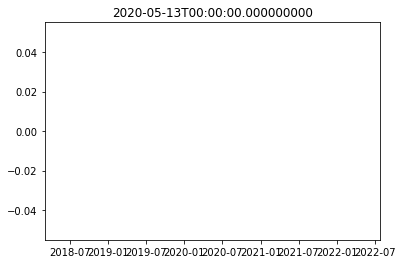

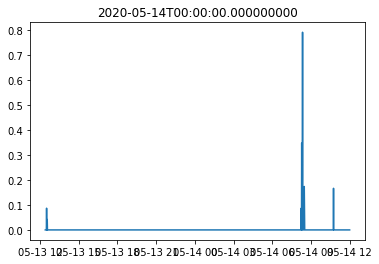

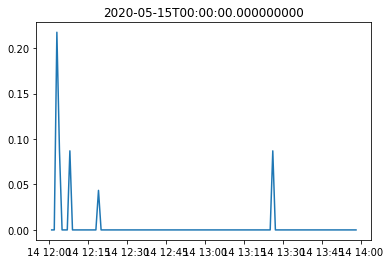

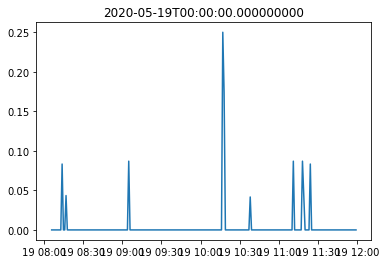

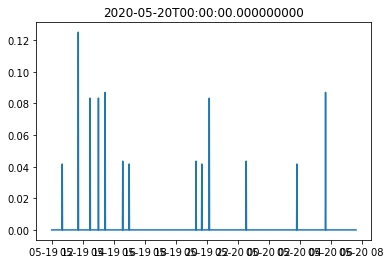

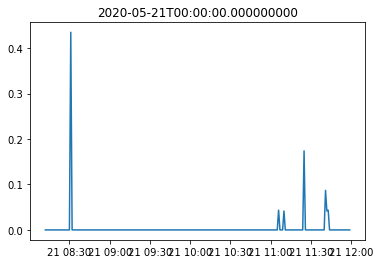

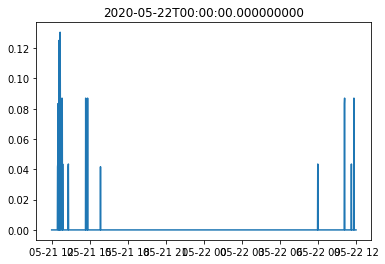

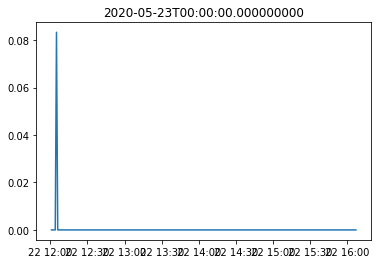

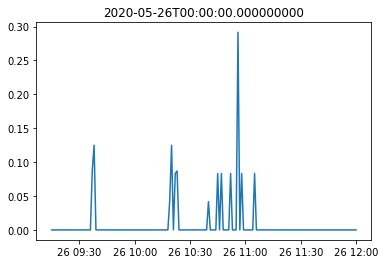

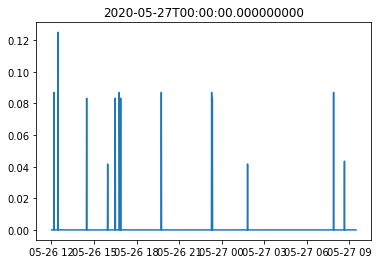

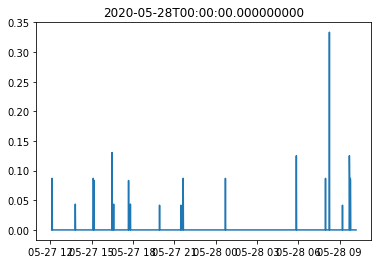

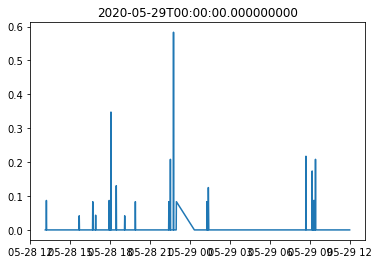

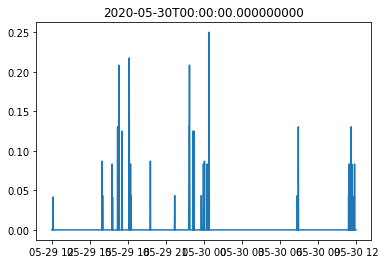

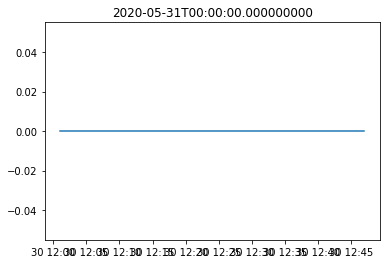

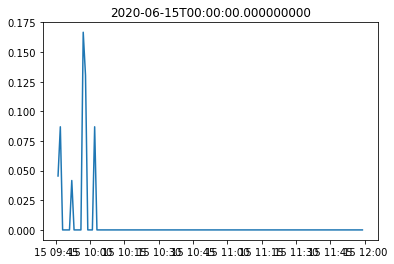

In [31]:
patients = ['RCS02','RCS05','RCS06','RCS07']
patients = ['RCS02']
for pt in patients:
    fn = glob.glob(os.path.join(path,'**','*%s*tremor_dyskinesia.csv' %pt),recursive=True)

    # put watch data into a dataframe - wd (watch data)
    wd = pd.read_csv(fn[0], header=0)
#     print(wd.info())
#     wd.plot.hist()
#     wd.describe()

    # get true/false re NaN's in dataframe
    tf_df = pd.isnull(wd).any(axis=1) # get boolean true if NaN's on any column 
    data_exists = wd[~tf_df].reset_index(drop=True)
    data_exists['timeStamp'] = pd.to_datetime(data_exists['timeStamp'])
    print(type(data_exists['timeStamp'][0]))
    data_exists.insert(loc=1, value=data_exists['timeStamp'].dt.round('d'), column='day') # df.insert puts column in specific place
    unique_days = data_exists['day'].dt.round('d').unique()

    for day in unique_days: 
        data_day = data_exists[data_exists['day'] == day]
        plt.plot(data_day['timeStamp'],data_day['tremor_mild'])
        plt.title(day)
        plt.show() # show plot, otherwise every plt.plot ends up in same figure
    break


    plt.figure(figsize = (16,8))

    # x-axis
    x_axis = np.arange(plotData.shape[0]) # indices for plotting
    xTicksInd = np.arange(0,plotData.shape[0],60) # indices to show every hour a timestamp
    xTickLabels = plotData['timeStamp']

    # wrist Feat
    wristY = plotData['wrist_Acc'].rolling(window=5).mean() # window is number of sample (minutes), change max/mean
    wristFeatX = np.arange(len(wristY))
    plt.plot(x_axis, wristY, label = 'wrist brady-proxy (max-acc in 15 min)', color = 'navy', linestyle = 'dotted')

        


In [27]:
data_exists

,timeStamp,days,tremor_mild,tremor_moderate,tremor_none,tremor_slight,tremor_strong,tremor_unknown,dyskinesia
0,2020-05-12 12:45:00,2020-05-13,0.0,0.0,0.526316,0.0,0.0,0.473684,0.0
1,2020-05-13 12:25:00,2020-05-14,0.0,0.0,0.526316,0.0,0.0,0.473684,0.0
2,2020-05-13 12:26:00,2020-05-14,0.0,0.0,0.260870,0.0,0.0,0.739130,0.0
3,2020-05-13 12:27:00,2020-05-14,0.0,0.0,0.347826,0.0,0.0,0.652174,0.0
4,2020-05-13 12:28:00,2020-05-14,0.0,0.0,0.208333,0.0,0.0,0.791667,0.0
...,...,...,...,...,...,...,...,...,...
7543,2020-06-15 11:55:00,2020-06-15,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0
7544,2020-06-15 11:56:00,2020-06-15,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0
7545,2020-06-15 11:57:00,2020-06-15,0.0,0.0,1.000000,0.0,0.0,0.000000,0.0
7546,2020-06-15 11:58:00,2020-06-15,0.0,0.0,0.958333,0.0,0.0,0.041667,0.0
